In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import matplotlib.pyplot as plt

device = torch.device("cuda")

In [ ]:
df = pd.read_csv("/kaggle/input/india-financial-news-headlines-sentiments/News_sentiment_Jan2017_to_Apr2021.csv")
df.head()

,Date,Title,URL,sentiment,confidence,Unnamed: 5
0,05/01/17,Eliminating shadow economy to have positive im...,http://economictimes.indiatimes.com/news/econo...,POSITIVE,0.996185,NaN
1,05/01/17,Two Chinese companies hit roadblock with India...,http://economictimes.indiatimes.com/news/econo...,NEGATIVE,-0.955493,NaN
2,05/01/17,SoftBank India Vision gets new $100,http://economictimes.indiatimes.com/small-biz/...,POSITIVE,0.595612,NaN
3,05/01/17,Nissan halts joint development of luxury cars ...,http://economictimes.indiatimes.com/news/inter...,NEGATIVE,-0.996672,NaN
4,05/01/17,Despite challenges Rajasthan continues to prog...,http://economictimes.indiatimes.com/news/polit...,POSITIVE,0.997388,NaN


In [ ]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Title'], df['sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

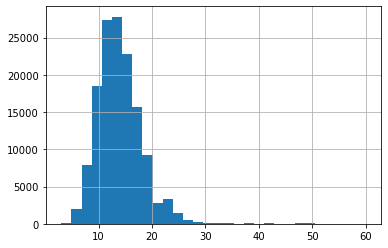

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train["input_ids"])
train_mask = torch.tensor(tokens_train["attention_mask"])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val["input_ids"])
val_mask = torch.tensor(tokens_val["attention_mask"])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test["input_ids"])
test_mask = torch.tensor(tokens_test["attention_mask"])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

optimizer = AdamW(model.parameters(),lr = 1e-5)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight("balanced", np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.92722276 1.08517482]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=85361     1
90122     1
190685    1
83116     0
143017    1
         ..
81525     1
99225     0
148483    1
177783    0
71976     0
Name: sentiment, Length: 140350, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
formatted_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

#defining epochs
epochs = 5

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()

    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of  4,386.
  Batch   100  of  4,386.
  Batch   150  of  4,386.
  Batch   200  of  4,386.
  Batch   250  of  4,386.
  Batch   300  of  4,386.
  Batch   350  of  4,386.
  Batch   400  of  4,386.
  Batch   450  of  4,386.
  Batch   500  of  4,386.
  Batch   550  of  4,386.
  Batch   600  of  4,386.
  Batch   650  of  4,386.
  Batch   700  of  4,386.
  Batch   750  of  4,386.
  Batch   800  of  4,386.
  Batch   850  of  4,386.
  Batch   900  of  4,386.
  Batch   950  of  4,386.
  Batch 1,000  of  4,386.
  Batch 1,050  of  4,386.
  Batch 1,100  of  4,386.
  Batch 1,150  of  4,386.
  Batch 1,200  of  4,386.
  Batch 1,250  of  4,386.
  Batch 1,300  of  4,386.
  Batch 1,350  of  4,386.
  Batch 1,400  of  4,386.
  Batch 1,450  of  4,386.
  Batch 1,500  of  4,386.
  Batch 1,550  of  4,386.
  Batch 1,600  of  4,386.
  Batch 1,650  of  4,386.
  Batch 1,700  of  4,386.
  Batch 1,750  of  4,386.
  Batch 1,800  of  4,386.
  Batch 1,850  of  4,386.
  Batch 1,900  of  4,386

In [ ]:
half_length = len(test_seq) // 30
reduced_test_seq = test_seq[:half_length]

reduced_test_mask = test_mask[:half_length]

with torch.no_grad():
    preds = model(reduced_test_seq.to(device), reduced_test_mask.to(device))
    preds = preds.detach().cpu().numpy()


preds = np.argmax(preds, axis = 1)

test_y=test_y[:half_length]
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       531
           1       0.74      0.72      0.73       471

    accuracy                           0.75      1002
   macro avg       0.75      0.75      0.75      1002
weighted avg       0.75      0.75      0.75      1002



In [ ]:
data1=pd.read_csv("/kaggle/input/gold-data/df2.csv")
data1

,Date,Title,URL,sentiment,confidence,Text,pct,pred,weight
0,2017-01-03,​Meenakshi Dawar and Varun Goel join Reliance ...,http://economictimes.indiatimes.com/mf/mf-news...,NEGATIVE,-0.838119,Get ready for some fund manager churning. Meen...,-0.041295,-0.013765,0.587823
1,2017-01-03,"Will follow Reliance Jio pricing , says Bharti...",http://www.financialexpress.com/industry/will-...,NEGATIVE,-0.925142,The Financial ExpressBharti Airtel chairman Su...,-0.041295,-0.013765,0.544311
2,2017-01-04,Reliance Jio Prime membership plan extended ti...,http://www.financialexpress.com/industry/techn...,POSITIVE,0.794206,The Financial ExpressReliance Jio has announce...,-2.356117,-0.785372,0.210211
3,2017-01-06,"Reliance Retail : Ladies , now de",http://economictimes.indiatimes.com/industry/s...,POSITIVE,0.964752,MUMBAI: Reliance Retail is launching stores wh...,0.069817,0.023272,0.529260
4,2017-01-06,Internet Trends Report highlights India mobile...,http://www.livemint.com/Technology/ssczejSaUSV...,NEGATIVE,-0.993098,New Delhi: The volume of wireless broadband da...,0.069817,0.023272,0.491815
...,...,...,...,...,...,...,...,...,...
1704,2021-09-03,Jio launches special JioFiber Business plans f...,https://www.businesstoday.in/technology/jio-la...,POSITIVE,0.884634,Reliance Jio on Tuesday announced integrated J...,3.398273,1.000000,0.942317
1705,2021-10-01,"With Improvement In Macros , Nifty Earnings Ex...",https://www.moneycontrol.com/news/business/mar...,POSITIVE,0.984251,"After a strong quarter of Q2FY21 earnings, the...",0.869320,0.289773,0.652761
1706,2021-10-02,"4G Auctions : Jio , Airtel , Vi to participate",https://economictimes.indiatimes.com/markets/s...,POSITIVE,0.701238,"MUMBAI: Telecom market leader Reliance Jio, se...",0.123385,0.041128,0.669945
1707,2021-10-02,"4G auctions : Jio , Airtel , Vodafone Idea to ...",https://economictimes.indiatimes.com/industry/...,POSITIVE,0.828440,"Telecom market leader Reliance Jio, second-ran...",0.123385,0.041128,0.606344


In [ ]:
test_text_2=data1['Title']
test_text_2

0       ​Meenakshi Dawar and Varun Goel join Reliance ...
1       Will follow Reliance Jio pricing , says Bharti...
2       Reliance Jio Prime membership plan extended ti...
3                       Reliance Retail : Ladies , now de
4       Internet Trends Report highlights India mobile...
                              ...                        
1704    Jio launches special JioFiber Business plans f...
1705    With Improvement In Macros , Nifty Earnings Ex...
1706       4G Auctions : Jio , Airtel , Vi to participate
1707    4G auctions : Jio , Airtel , Vodafone Idea to ...
1708    Stock Market Updates Today : Sensex opens 363 ...
Name: Title, Length: 1709, dtype: object

In [ ]:
tokens_test = tokenizer.batch_encode_plus(
    test_text_2.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
data1['sentiment'] = label_encoder.fit_transform(data1['sentiment'])
test_labels_2=data1['sentiment']

In [ ]:
test_seq_2 = torch.tensor(tokens_test["input_ids"])
test_mask_2 = torch.tensor(tokens_test["attention_mask"])
test_y_2 = torch.tensor(test_labels_2.tolist())

In [ ]:
half_length = len(test_seq_2)
reduced_test_seq = test_seq_2[:half_length]

reduced_test_mask = test_mask_2[:half_length]

with torch.no_grad():
    preds_2 = model(reduced_test_seq.to(device), reduced_test_mask.to(device))
    preds_2 = preds_2.detach().cpu().numpy()

sentiment_score=preds_2
preds_2 = np.argmax(preds_2, axis = 1)

test_y_2=test_y_2[:half_length]
print(classification_report(test_y_2, preds_2))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       833
           1       0.73      0.81      0.77       876

    accuracy                           0.75      1709
   macro avg       0.75      0.75      0.75      1709
weighted avg       0.75      0.75      0.75      1709



In [ ]:
sentiment_score

array([[-0.51538056, -0.909497  ],
       [-0.3957571 , -1.1183156 ],
       [-1.2454479 , -0.3394133 ],
       ...,
       [-1.4007888 , -0.28289697],
       [-1.5759963 , -0.23168167],
       [-1.063103  , -0.423704  ]], dtype=float32)

In [ ]:
final_data=pd.DataFrame(sentiment_score, columns=['NEGATIVE', 'POSITIVE'])
final_data.to_csv('output.csv', index=False)

In [ ]:
final_data['sentiment']= preds_2
final_data

,NEGATIVE,POSITIVE,sentiment
0,-0.515381,-0.909497,0
1,-0.395757,-1.118316,0
2,-1.245448,-0.339413,1
3,-1.971997,-0.149868,1
4,-0.390942,-1.128308,0
...,...,...,...
1704,-1.104924,-0.402324,1
1705,-1.713931,-0.198641,1
1706,-1.400789,-0.282897,1
1707,-1.575996,-0.231682,1


In [ ]:
def normalize_weights(row):
    total = abs(row['NEGATIVE']) + abs(row['POSITIVE'])
    row['NEGATIVE'] = row['NEGATIVE'] / total
    row['POSITIVE'] = row['POSITIVE'] / total
    return row

# Apply the function to each row
final_data[['NEGATIVE', 'POSITIVE']] = final_data[['NEGATIVE', 'POSITIVE']].apply(normalize_weights, axis=1)

print(final_data)

      NEGATIVE  POSITIVE  sentiment
0    -0.361702 -0.638298          0
1    -0.261386 -0.738614          0
2    -0.785840 -0.214160          1
3    -0.929370 -0.070630          1
4    -0.257326 -0.742674          0
...        ...       ...        ...
1704 -0.733074 -0.266926          1
1705 -0.896139 -0.103861          1
1706 -0.831978 -0.168022          1
1707 -0.871835 -0.128165          1
1708 -0.715024 -0.284976          1

[1709 rows x 3 columns]


In [ ]:
final_data['score'] = final_data.apply(lambda row: -abs(row['NEGATIVE']) if row['sentiment'] == 0 else abs(row['POSITIVE']), axis=1)

In [ ]:
final_data.to_csv('output2.csv', index=False)

In [ ]:
final_data['score'].describe()

count    1709.000000
mean        0.016493
std         0.254074
min        -0.499477
25%        -0.170630
50%         0.046382
75%         0.203827
max         0.499613
Name: score, dtype: float64

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(data1.iterrows(), total=len(data1)):
    text = row['Text']
    myid = row['Date']
    res[myid] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Date'})
vaders = vaders.merge(data1, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

,Date,neg,neu,pos,compound,Title,URL,sentiment,confidence,Text,pct,pred,weight
0,2017-01-03,0.044,0.905,0.051,0.1506,​Meenakshi Dawar and Varun Goel join Reliance ...,http://economictimes.indiatimes.com/mf/mf-news...,0,-0.838119,Get ready for some fund manager churning. Meen...,-0.041295,-0.013765,0.587823
1,2017-01-03,0.044,0.905,0.051,0.1506,"Will follow Reliance Jio pricing , says Bharti...",http://www.financialexpress.com/industry/will-...,0,-0.925142,The Financial ExpressBharti Airtel chairman Su...,-0.041295,-0.013765,0.544311
2,2017-01-04,0.021,0.869,0.110,0.9930,Reliance Jio Prime membership plan extended ti...,http://www.financialexpress.com/industry/techn...,1,0.794206,The Financial ExpressReliance Jio has announce...,-2.356117,-0.785372,0.210211
3,2017-01-06,0.027,0.910,0.063,0.9564,"Reliance Retail : Ladies , now de",http://economictimes.indiatimes.com/industry/s...,1,0.964752,MUMBAI: Reliance Retail is launching stores wh...,0.069817,0.023272,0.529260
4,2017-01-06,0.027,0.910,0.063,0.9564,Internet Trends Report highlights India mobile...,http://www.livemint.com/Technology/ssczejSaUSV...,0,-0.993098,New Delhi: The volume of wireless broadband da...,0.069817,0.023272,0.491815


In [ ]:
vaders['compound'].describe()

count    1709.000000
mean        0.797164
std         0.506831
min        -0.998600
25%         0.930000
50%         0.983300
75%         0.994200
max         1.000000
Name: compound, dtype: float64

In [ ]:
vaders.to_csv('output3.csv', index=False)

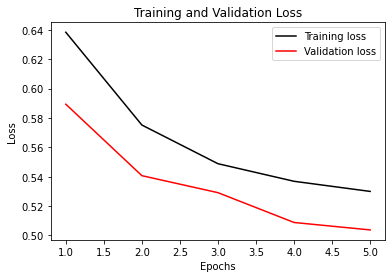

In [ ]:
# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.plot(epochs, train_losses, 'black', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()